# Idempotent Generative Network
Implementation of the paper [Idempotent Generative Network](https://arxiv.org/abs/2311.01462).

## Import libraries

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Union, Optional
from torch.nn.common_types import _size_2_t

Set random seed for reproducibility

In [12]:
manual_seed = 1337
np.random.seed(manual_seed)
torch.manual_seed(manual_seed)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## DCGAN Autoencoder
The paper explains the idempotent function $f$, to be an autoencoder. Specifically the discuss an architecture where the encoder is a simple five-layer discriminator backbone from [DCGAN](https://arxiv.org/abs/1511.06434), and the decoder is the generator. We implement this now.

From the DCGAN paper:
Architecture guidelines for stable Deep Convolutional GANs
* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
* Use batchnorm in both the generator and the discriminator.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in generator for all layers except for the output, which uses Tanh.
* Use LeakyReLU activation in the discriminator for all layers.

In [13]:
# Convolutional layer applying:
# Conv2D -> BatchNorm (optional) -> Non-linear activation (optional).
class Conv(nn.Module):
  def __init__(self,
               in_channels: int,
               out_channels: int,
               kernel_size: _size_2_t,
               stride: _size_2_t = 1,
               padding: Union[str, _size_2_t] = 0,
               batch_norm: bool = True,
               nonlinearity: str = 'relu',
               transposed: bool = False):
      super().__init__()
      self.conv = (nn.ConvTranspose2d if transposed else nn.Conv2d)(in_channels, out_channels, kernel_size, stride, padding)
      nn.init.normal_(self.conv.weight, .0, 0.02) # Papers suggests initializing weights from Normal(0.0, 0.02).
      nn.init.constant_(self.conv.bias.data, 0)
      #nn.init_normal_(self.bn.weight, .0, .02)
      #nn.init_constant_(self.bn.bias.data, 0)
      self.bn = nn.BatchNorm2d(out_channels, affine=False) if batch_norm else nn.Identity() # Authors suggest removing scale and bias parameter.
      match nonlinearity:
        case 'relu':
          self.nonlinearity = nn.ReLU(inplace=True) #Inplace can be faster/more memory efficient. But weird things can happen
        case 'leaky':
          self.nonlinearity = nn.LeakyReLU(.2, inplace=True) # As suggested in the DCGAN paper.
        case 'tanh':
          self.nonlinearity = nn.Tanh()
        case _:
          self.nonlinearity = nn.Identity()
      self.sequential = nn.Sequential(self.conv, self.bn, self.nonlinearity)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.sequential(x)

# Implemented as a DCGAN discriminator.
# Ignore applying Sigmoid at the end.
class Encoder(nn.Module):
  def __init__(self,
               in_channels: int = 3,
               nz=64,
               ngf=64):
    super().__init__()
    self.sequential = nn.Sequential(
      Conv(in_channels=in_channels, out_channels=64, kernel_size=4, stride=2, padding=1, batch_norm=False, nonlinearity='leaky', transposed=False),
      Conv(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, batch_norm=True, nonlinearity='leaky', transposed=False),
      Conv(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, batch_norm=True, nonlinearity='leaky', transposed=False),
      Conv(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, batch_norm=True, nonlinearity='leaky', transposed=False),
      Conv(in_channels=512, out_channels=512, kernel_size=4, stride=1, padding=0, batch_norm=False, nonlinearity=None, transposed=False))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.sequential(x)

# Implemented as a DCGAN generator.
class Decoder(nn.Module):
  def __init__(self,
               out_channels: int = 3):
    super().__init__()
    self.sequential = nn.Sequential(
      Conv(in_channels=512, out_channels=512, kernel_size=4, stride=1, padding=0, batch_norm=True, nonlinearity='relu', transposed=True),
      Conv(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, batch_norm=True, nonlinearity='relu', transposed=True),
      Conv(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, batch_norm=True, nonlinearity='relu', transposed=True),
      Conv(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, batch_norm=True, nonlinearity='relu', transposed=True),
      Conv(in_channels=64, out_channels=out_channels, kernel_size=4, stride=2, padding=1, batch_norm=False, nonlinearity='tanh', transposed=True))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.sequential(x)

# in_channels = 3, out channels = 3, for RGB image.
# in_channels = 1, out_channels = 1, for greyscale.
class AutoEncoder(nn.Module):
  def __init__(self,
               in_channels: int = 3,
               out_channels: int = 3):
    super().__init__()
    self.encoder = Encoder(in_channels)
    self.decoder = Decoder(out_channels)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.decoder(self.encoder(x))

In [14]:
def visualize_image(image: torch.Tensor):
  plt.imshow(image.squeeze(), cmap='gray')
  plt.show()

## Instantiate model

In [15]:
f = AutoEncoder(in_channels=1, out_channels=1).to(device)
f.load_state_dict(torch.load("IGN_epoch_300.pt"))
print("Loaded model.")

Loaded model.


<ipython-input-15-8b10e9d0d74f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  f.load_state_dict(torch.load("IGN_epoch_300.pt"))


In [16]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

def compare_imgs(img1, img2, i):
  # From Skimage SSIM documentation
  mse_none = mean_squared_error(img1, img1)
  mse_comp = mean_squared_error(img1, img2)

  ssim_none = ssim(img1, img1, data_range = max(img1.max(), img1.max()) - min(img1.min(), img1.min()))
  ssim_comp = ssim(img1, img2, data_range = max(img1.max(), img2.max()) - min(img1.min(), img2.min()))

  l2_comp = np.linalg.norm(img1 - img2)

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, sharey=True)
  ax = axes.ravel()

  ax[0].imshow(img1, cmap=plt.cm.gray, vmin=0, vmax=1)
  #ax[0].set_xlabel(f'MSE: {mse_none:.2f}, SSIM: {ssim_none:.2f}')
  ax[0].set_title('Original image')

  ax[1].imshow(img2, cmap=plt.cm.gray, vmin=0, vmax=1)
  ax[1].set_xlabel(f'MSE: {mse_comp:.2f}, SSIM: {ssim_comp:.2f}, L2: {l2_comp:.2f}')
  ax[1].set_title('Comparing image, i = ' + str(i))

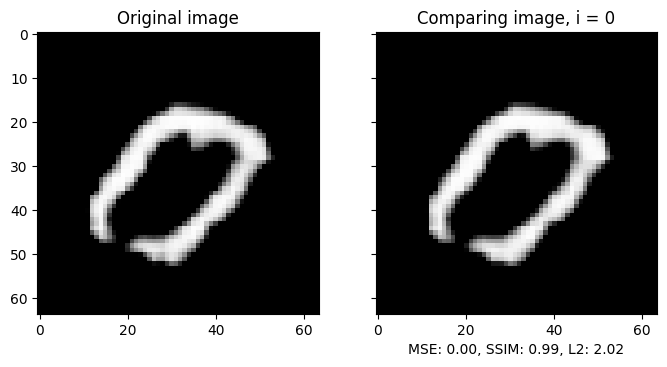

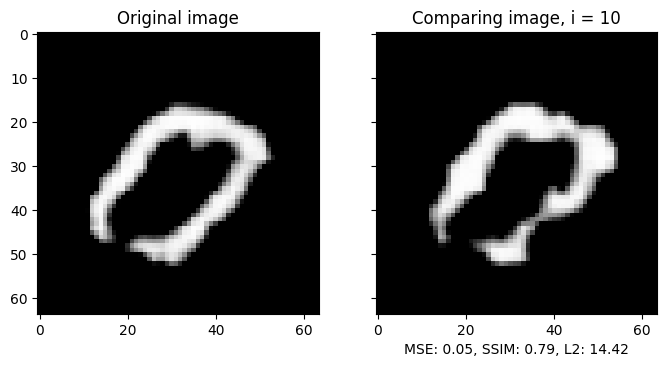

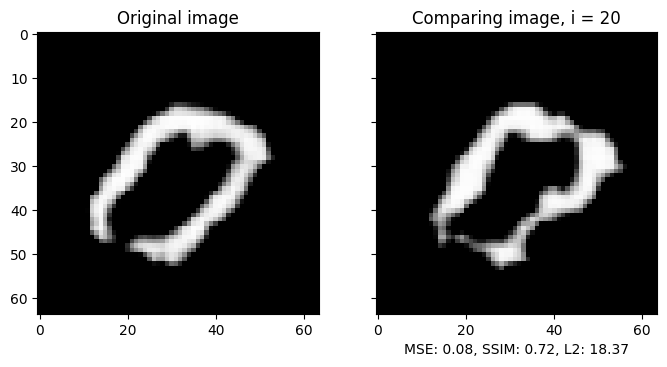

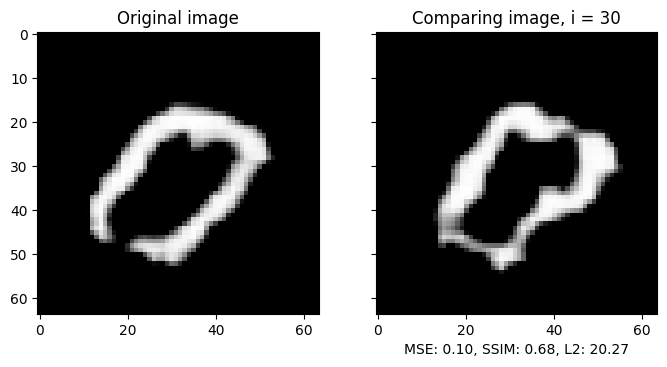

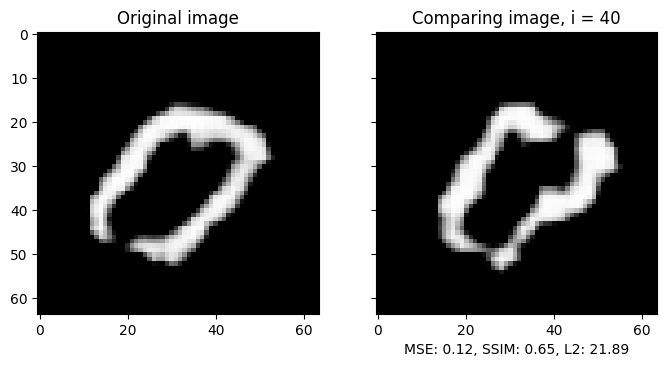

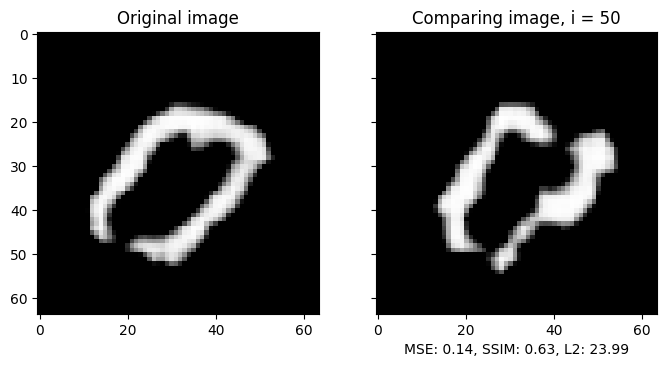

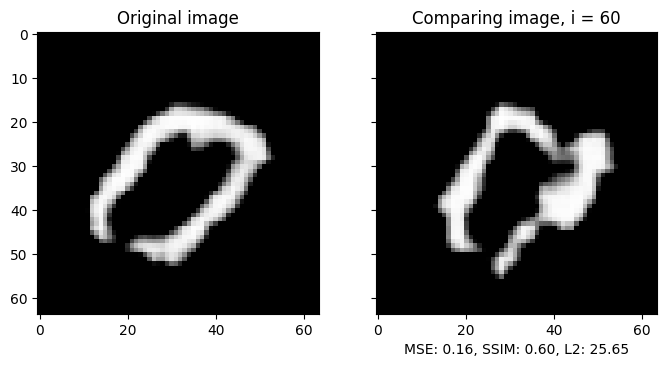

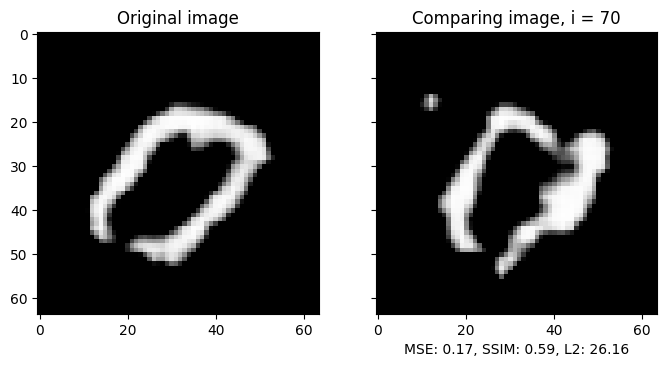

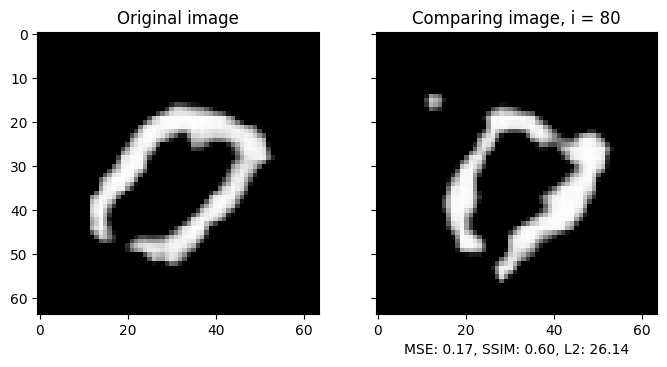

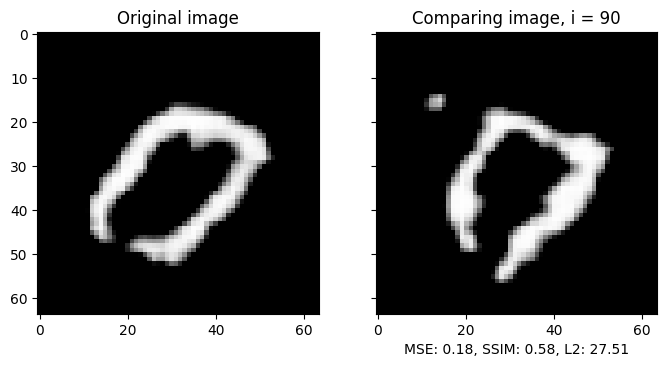

In [17]:
x = f(torch.randn((1, 1, 64, 64)).to(device)).detach()
x_orig = x.cpu().numpy()[0, 0]

for i in range(100):
  x = f(x).detach()

  if i % 10 == 0:
    compare_imgs(x_orig, x.cpu().numpy()[0, 0], i)

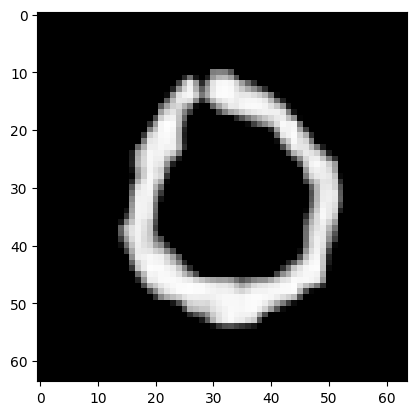

100%|██████████| 10000/10000 [00:26<00:00, 374.79it/s]


In [18]:
# Generate a random image to follow
x = f(torch.randn((1, 1, 64, 64)).to(device))
x_orig = x.detach().cpu().numpy()[0, 0]

plt.imshow(x_orig, cmap=plt.cm.gray, vmin=0, vmax=1)
plt.show()

n_its = 10000

mse_l = [None] * n_its
ssim_l = [None] * n_its
l2_l = [None] * n_its

def calc_metrics(img1, img2):
  mse_comp = mean_squared_error(img1, img2)
  ssim_comp = ssim(img1, img2, data_range = max(img1.max(), img2.max()) - min(img1.min(), img2.min()))
  l2_comp = np.linalg.norm(img1 - img2)

  return mse_comp, ssim_comp, l2_comp

for i in tqdm(range(n_its)):
  x = f(x).detach()
  mse_l[i], ssim_l[i], l2_l[i] = calc_metrics(x_orig, x.cpu().numpy()[0, 0])


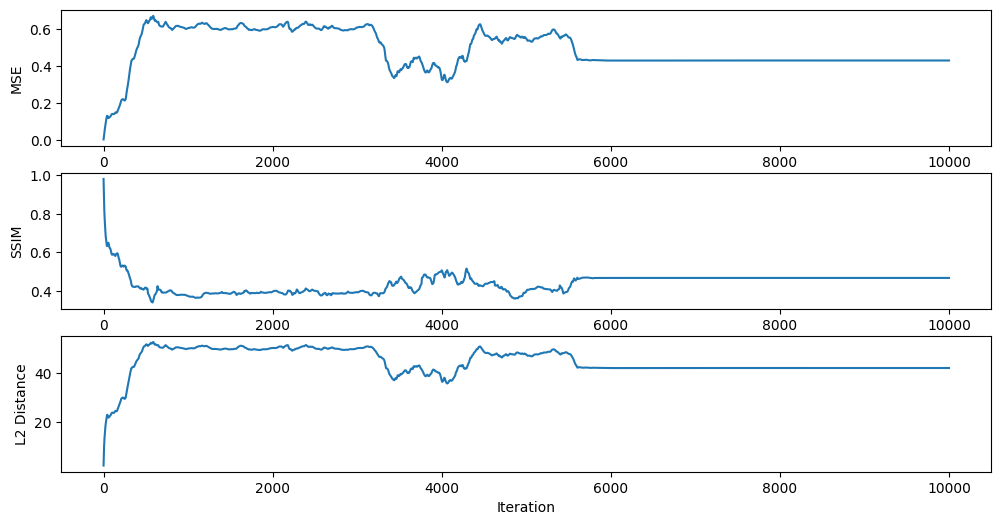

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
ax = axes.ravel()

ax[0].plot(mse_l)
#ax[0].set_title('Mean Square Error')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('MSE')

ax[1].plot(ssim_l)
#ax[1].set_title('Structural Similarity Index Measure')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('SSIM')

ax[2].plot(l2_l)
#ax[2].set_title('L2 Distance')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('L2 Distance')

plt.show()

In [20]:
# Stress test for 6 random generated images
imgs = []

for i in tqdm(range(300001)):
    if i == 0:
        x = torch.randn((6, 1, 64, 64)).to(device)

    else:
        x = f(x).detach()

    if i in [0, 1, 10, 20, 100, 1000, 10000, 100000, 300000]:
        imgs += [p[0] for p in x.cpu().numpy()]

100%|██████████| 300001/300001 [09:58<00:00, 500.88it/s]


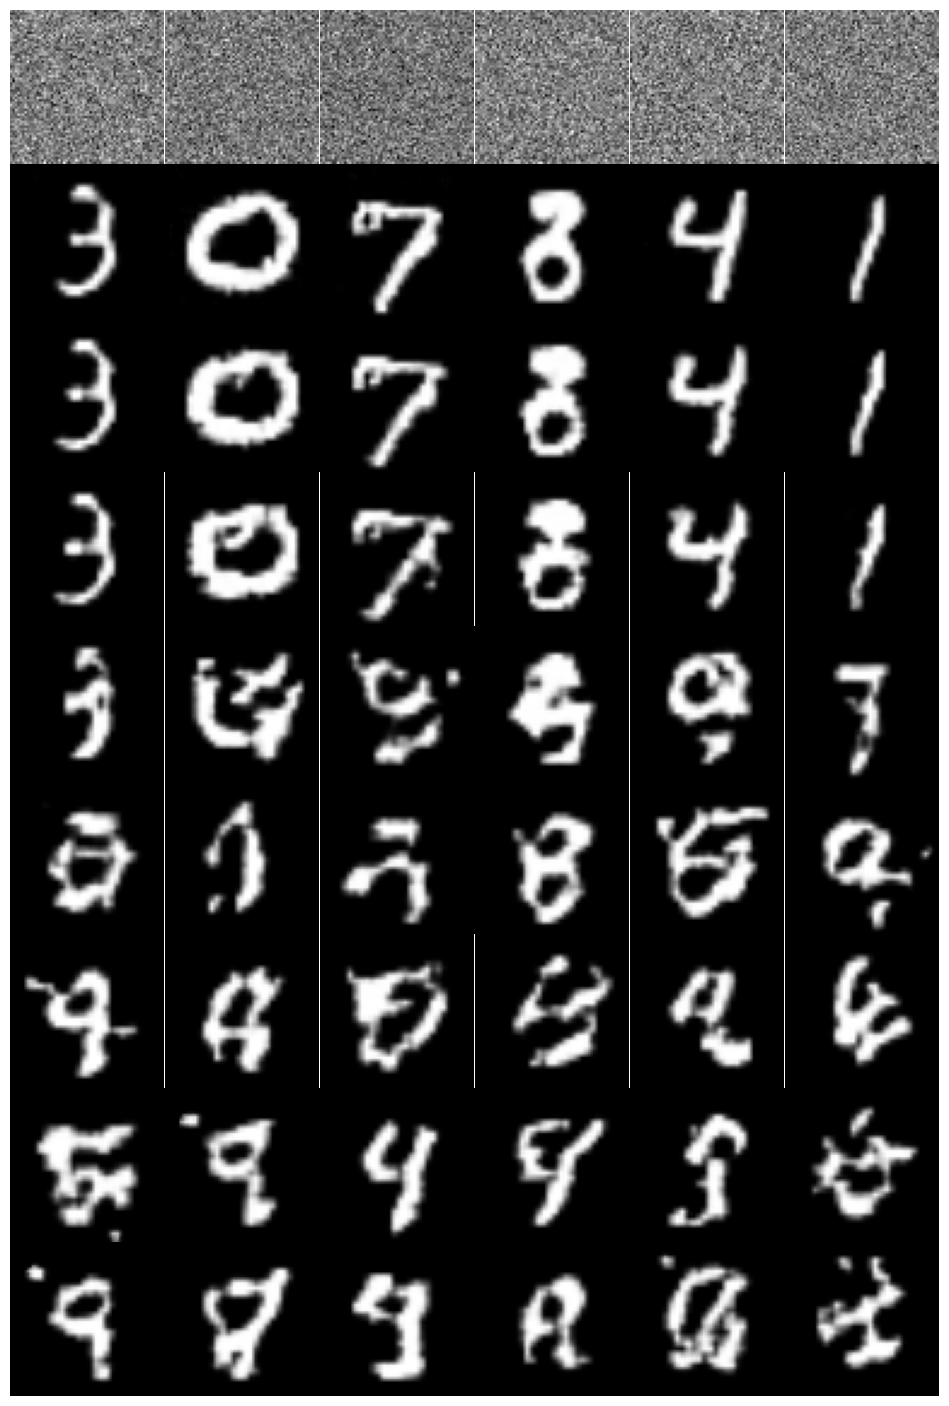

In [21]:
import matplotlib.gridspec as gridspec

n_rows = 9
n_cols = 6

fig = plt.figure(figsize=(n_cols * 2, n_rows * 2))
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, wspace=0, hspace=0)

for i in range(n_rows * n_cols):
    ax = fig.add_subplot(gs[i])

    ax.imshow(imgs[i], cmap='gray')
    ax.axis('off')

plt.show()

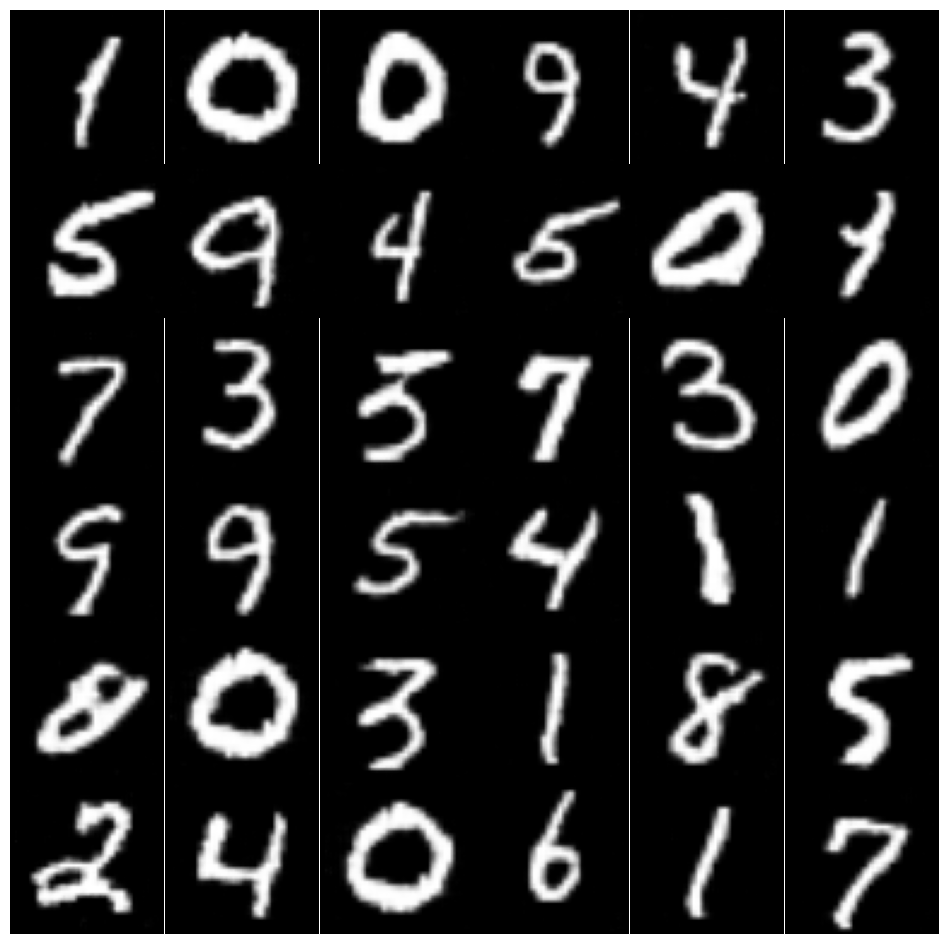

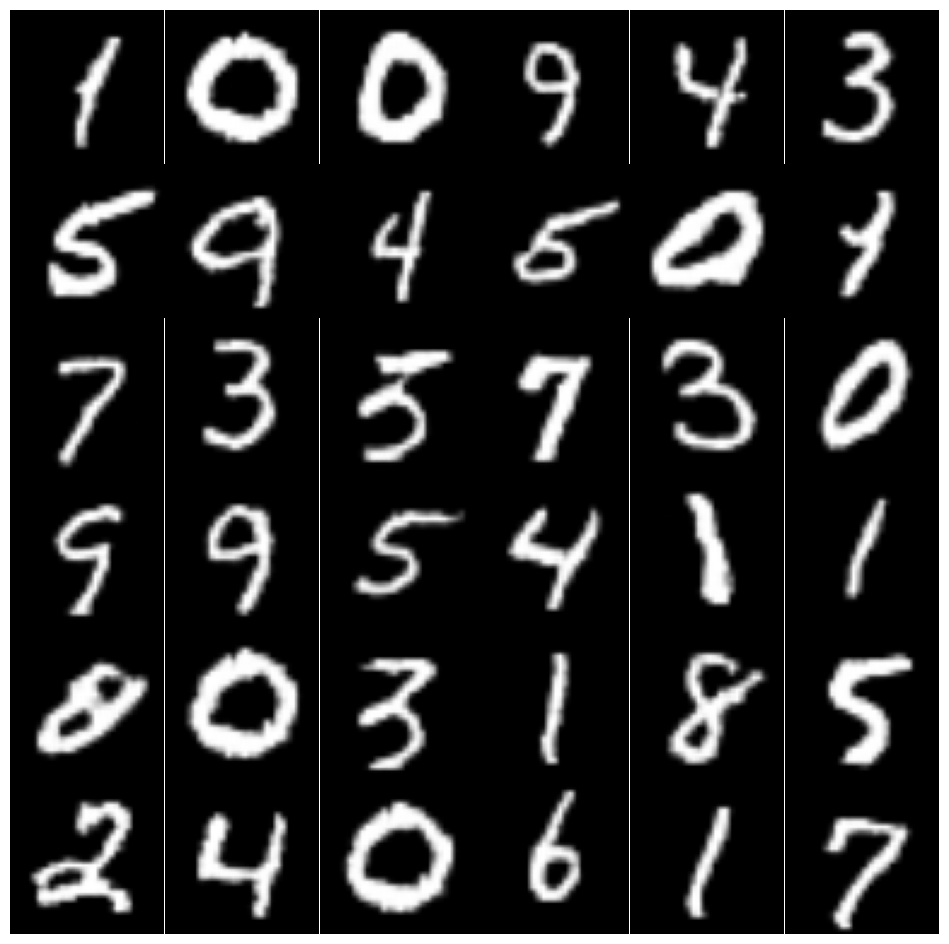

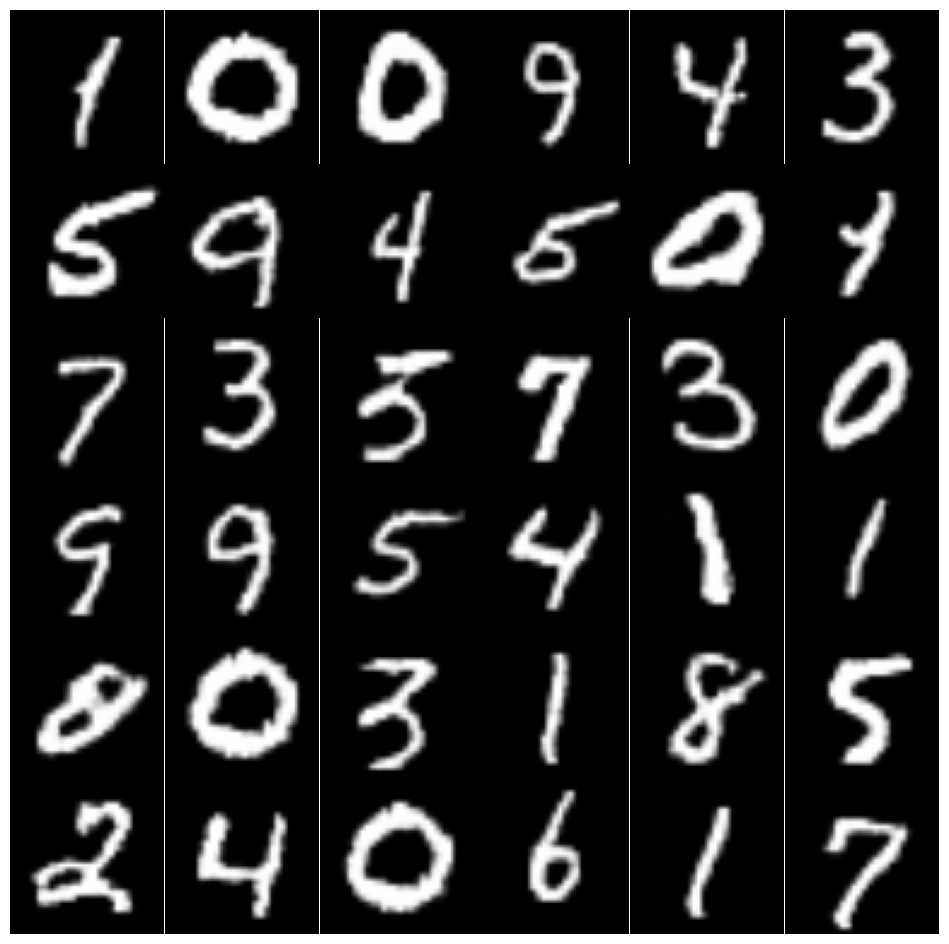

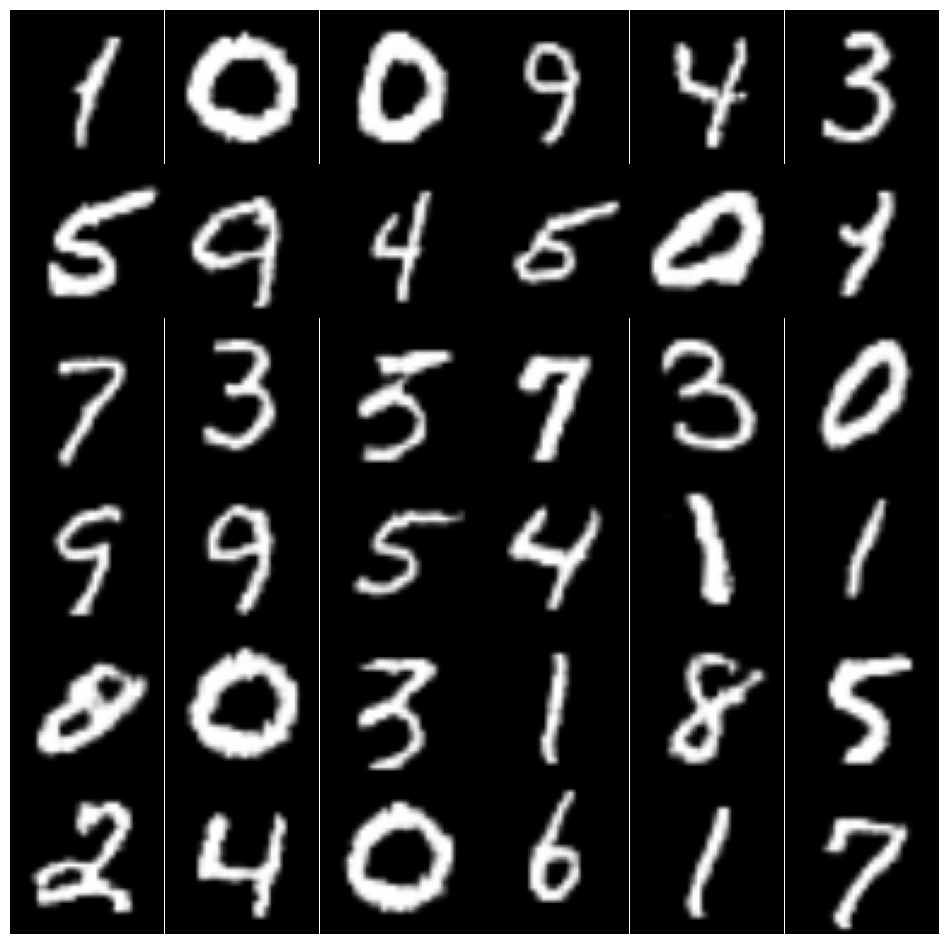

In [22]:
batch = torch.randn((36, 1, 64, 64)).to(device)

def plot_gall(n_rows, n_cols, imgs):
    fig = plt.figure(figsize=(n_cols * 2, n_rows * 2))
    gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, wspace=0, hspace=0)

    for i in range(n_rows * n_cols):
        ax = fig.add_subplot(gs[i])

        ax.imshow(imgs[i][0].cpu(), cmap='gray')
        ax.axis('off')

    plt.show()

fx = f(batch).detach()
plot_gall(6, 6, [x for x in fx])
fx = f(fx).detach()
plot_gall(6, 6, [x for x in fx])
fx = f(fx).detach()
plot_gall(6, 6, [x for x in fx])
fx = f(fx).detach()
plot_gall(6, 6, [x for x in fx])

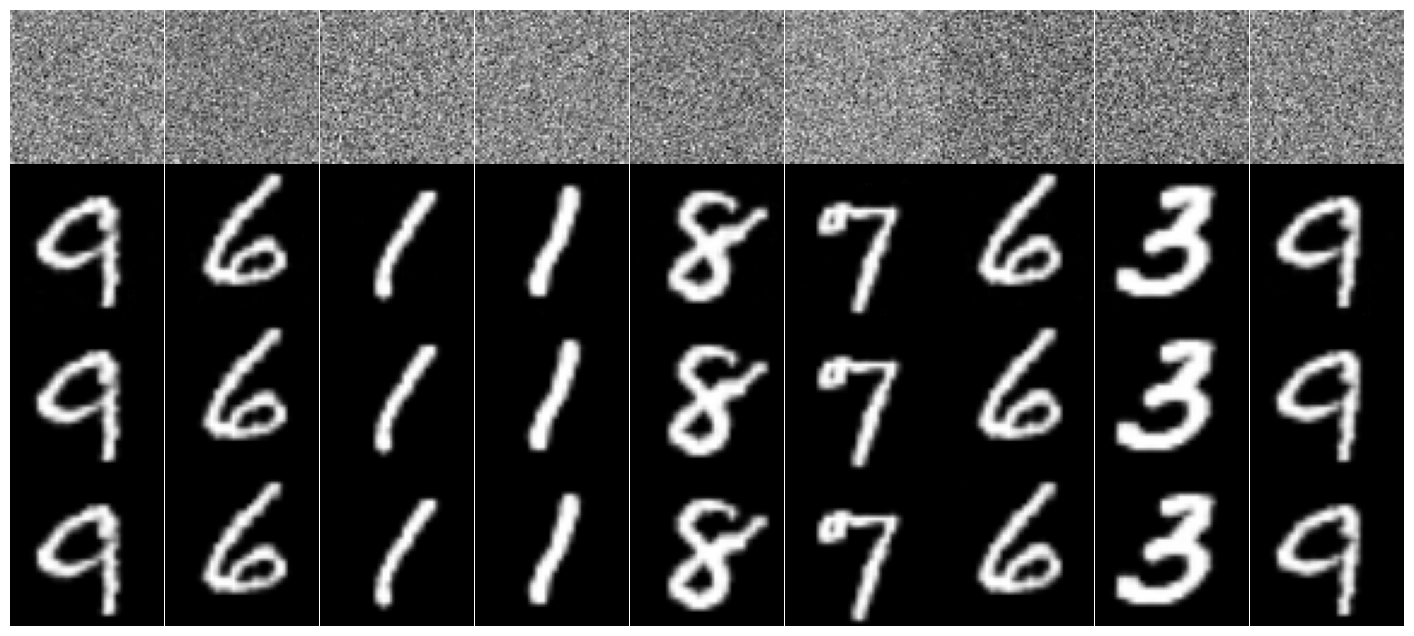

In [23]:
batch = torch.randn((9, 1, 64, 64)).to(device)

fx = f(batch).detach()
ffx = f(fx).detach()
fffx = f(ffx).detach()
plot_gall(4, 9, [x for x in batch] + [x for x in fx] + [x for x in ffx] + [x for x in fffx])